# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Colin Hui
- Derek Aslan
- Aydan Ali
- Conor Cummings

In [249]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import probplot, shapiro

In [250]:
# function to clean data

def clean_data(original_csv):
    """  
    Cleans the data from the original CSV file by handling missing/null values

    Args:
        original_csv (str): The path to the original CSV file we produced in Phase II.

    Returns:
        pandas.DataFrame: A cleaned DataFrame with missing/null values handled
    """

    df = pd.read_csv(original_csv, index_col=0)

    null_count = df.isnull().sum()
    null_pct = (null_count) / len(df) * 100

    null_df = pd.DataFrame({'null_count': null_count, 'null_pct': null_pct})

    # Drop rows where the target variable 'VA.EST' is null
    df_clean = df.dropna(subset=['VA.EST'])  
    
    # calculating null percentages for each column after removing rows with null target values
    null_pct_clean = (df_clean.isnull().sum()) / len(df_clean) * 100
    
    # finding columns that have more than 40% null values - extract column names and store in a list
    drop_columns = null_pct_clean[null_pct_clean > 40].index.tolist()
    if drop_columns:
        # .drop function to drop columns with more than 40% null values
        df_clean = df_clean.drop(columns=drop_columns)
    
    
    # trying to maximize rows by imputing missing values for remaining columns if there arent a great # of nulls
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            null_pct = df_clean[col].isnull().sum() / len(df_clean) * 100

            if null_pct < 10:
                # median is better to use compared to mean since it is less affected by outliers
                df_clean[col] = df_clean[col].fillna(df_clean[col].median())
            else:
                df_clean = df_clean.dropna(subset = [col])

    
    return df_clean
    

In [251]:
df = clean_data('world_bank_data_2023.csv')
print(df)

    SP.POP.TOTL  NY.GNP.PCAP.CD  MS.MIL.XPND.GD.ZS    VA.EST  \
AO   36749906.0          2130.0           1.332529 -0.737252   
AL    2745972.0          7680.0           1.743992  0.168997   
AR   45538401.0         12890.0           0.472747  0.533922   
AM    2964300.0          6840.0           5.450925  0.076708   
AU   26652777.0         63160.0           1.922199  1.506602   
..          ...             ...                ...       ...   
VE   28300854.0          6720.0           0.500704 -1.531321   
XK    1682668.0          6290.0           1.254180 -0.088809   
ZA   63212384.0          6480.0           0.733137  0.744892   
ZM   20723965.0          1290.0           1.303002 -0.047946   
ZW   16340822.0          2060.0           0.248808 -1.092633   

                        region          incomeLevel  
AO         Sub-Saharan Africa   Lower middle income  
AL       Europe & Central Asia  Upper middle income  
AR  Latin America & Caribbean   Upper middle income  
AM       Europe

### Attempt 1 - Linear Regression

In [262]:
def evaluate_model(X, y):
    """
    Fit a simple linear regression model and evaluate with R^2 and MSE.
    
    Args:
        X (DataFrame or array): Feature values (GDP, Military Spending, Population)
        y (Series or array): Target values (Voice & Accountability)
    
    Returns:
        Trained model with evaluation metrics
    """
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Model evaluation
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    print(f"MSE:: {mse:.4f}")
    print(f"R^2: {r2:.4f}")
    
    y_pred = model.predict(X)
    residuals = y - y_pred

    fig, axes = plt.subplots(1, 4, figsize = (16, 4))

    # independence - residuals vs order
    axes[0].scatter(range(len(residuals)), residuals, alpha=0.5)
    axes[0].axhline(0, color = 'red', linestyle='--')
    axes[0].set_title('Independence: Residuals vs Order', size = 11)
    axes[0].set_xlabel('Index')
    axes[0].set_ylabel('Residuals')

    # Residuals vs Fitted
    axes[1].scatter(y_pred, residuals, alpha = 0.5)
    axes[1].axhline(0, color = 'red', linestyle = '--')
    axes[1].set_title('Homoscedasticity: Residuals vs Fitted', size = 11)
    axes[1].set_xlabel('Fitted Values')
    axes[1].set_ylabel('Residuals')

    # Q-Q plot (Normality)
    probplot(residuals, dist="norm", plot=axes[2])
    axes[2].set_title('Normality: Q-Q Plot')

    # Histogram of residuals (normality)
    axes[3].hist(residuals, bins=20, edgecolor='black', alpha=0.5)
    axes[3].set_title('Normality: Residuals Histogram')
    axes[3].set_xlabel('Residuals')
    axes[3].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return model


MSE:: 0.4279
R^2: 0.5403


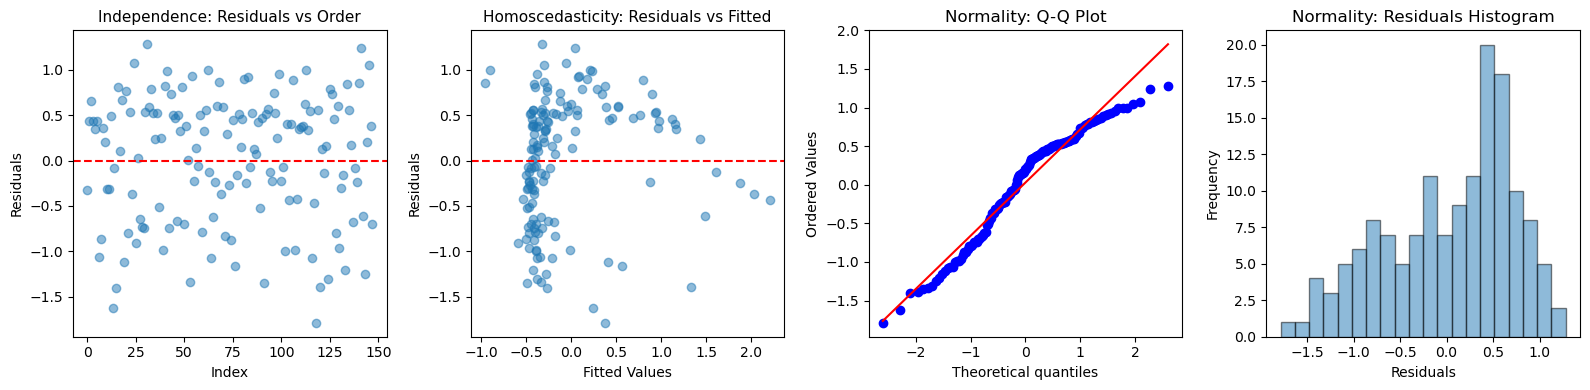

In [260]:
# Define features and target - trying to predict Voice & Accountability from all the other indicators
X = df[['NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'SP.POP.TOTL']]
y = df['VA.EST']

# Evaluating simple linear regression model
model = evaluate_model(X, y)

### Attempt 2 - Polynomial Regression

Polynomial Regression MSE: 0.6310
Polynomial Regression R^2: 0.3900


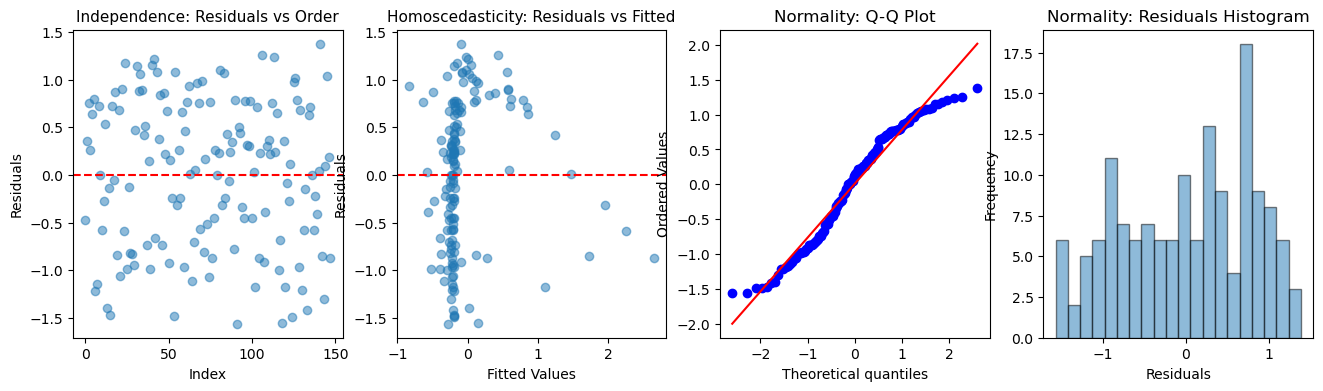

In [264]:
X = df[['NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'SP.POP.TOTL']]
y = df['VA.EST']

# the 'LinearRegression' function already introduces bias column
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=8)

model = LinearRegression()
model.fit(X_train, y_train)

# get predictions on test set
y_pred_test = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Polynomial Regression MSE: {mse:.4f}")
print(f"Polynomial Regression R^2: {r2:.4f}")

y_pred = model.predict(X_poly)
residuals = y - y_pred

fig, axes = plt.subplots(1, 4, figsize = (16, 4))   

# independence - residuals vs order
axes[0].scatter(range(len(residuals)), residuals, alpha = 0.5)
axes[0].axhline(0, color = 'red', linestyle='--')
axes[0].set_title('Independence: Residuals vs Order', size = 11)
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Residuals')

# Residuals vs Fitted
axes[1].scatter(y_pred, residuals, alpha = 0.5)
axes[1].axhline(0, color = 'red', linestyle = '--') 
axes[1].set_title('Homoscedasticity: Residuals vs Fitted', size = 11)
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')

# Q-Q plot (Normality)
probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Normality: Q-Q Plot')

# Histogram of residuals (normality)
axes[3].hist(residuals, bins=20, edgecolor='black', alpha=0.5)
axes[3].set_title('Normality: Residuals Histogram')
axes[3].set_xlabel('Residuals')
axes[3].set_ylabel('Frequency')



plt.tight_layout
plt.show()

### Extra Attempt: K-nearest neighbors (predicting **'Region'**)

In [239]:
# put the csv back into a DataFrame
df = pd.read_csv('world_bank_data_2023.csv', index_col=0)

# Clean the data and remove rows with missing values for variables we're using
df_clean = df.dropna(subset=['NY.GNP.PCAP.CD', 'VA.EST', 'SP.POP.TOTL', 'MS.MIL.XPND.GD.ZS', 'region'])
df_clean

,SP.POP.TOTL,NY.GNP.PCAP.CD,SI.POV.DDAY,SI.POV.GINI,MS.MIL.XPND.GD.ZS,VA.EST,region,incomeLevel
AO,36749906.0,2130.0,NaN,NaN,1.332529,-0.737252,Sub-Saharan Africa,Lower middle income
AL,2745972.0,7680.0,NaN,NaN,1.743992,0.168997,Europe & Central Asia,Upper middle income
AR,45538401.0,12890.0,1.2,42.4,0.472747,0.533922,Latin America & Caribbean,Upper middle income
AM,2964300.0,6840.0,1.9,27.2,5.450925,0.076708,Europe & Central Asia,Upper middle income
AU,26652777.0,63160.0,NaN,NaN,1.922199,1.506602,East Asia & Pacific,High income
...,...,...,...,...,...,...,...,...
US,336806231.0,80710.0,1.2,41.8,3.361836,0.877519,North America,High income
XK,1682668.0,6290.0,NaN,NaN,1.254180,-0.088809,Europe & Central Asia,Upper middle income
ZA,63212384.0,6480.0,NaN,NaN,0.733137,0.744892,Sub-Saharan Africa,Upper middle income
ZM,20723965.0,1290.0,NaN,NaN,1.303002,-0.047946,Sub-Saharan Africa,Lower middle income


In [240]:
def kNN(k, train_x, train_y, x_real, distance_function):
    """
    Performs a k-nearest-neighbors classification on a data point x_real.
    Args:
        k: the number of neighbors
        train_x: a dataframe containing a set of reference data entries
        train_y: a dataframe containing the corresponding set of classifications for train_x
        x_real: a dataframe containing the target to classify
        distance_function (input1, input2) : a function that returns the distance between two data points.
            Args:
                input1: a dictionary of values corresponding to a data point
                input2: another such dictionary
            Returns:
                distance: a number representing the distance between the data points.

    Returns:
        y_prediction: a predicted classification for x_real
    """

    train_x_dict = train_x.to_dict('index')
    train_y_dict = train_y.to_dict()    
    distances = {}
    for key in train_x_dict.keys():
        distances[key] = distance_function(train_x_dict[key], x_real)
    sorted_distances = sorted(distances.items(), key=lambda item: item[1])
    neighbors = []
    for i in range(k):
        neighbors.append(train_y_dict[sorted_distances[i][0]])
    return max(set(neighbors), key=neighbors.count)

In [241]:
def kNN_Simple(k, x_real):
    """
    A simplified version of kNN which automatically selects the training data and distance function.
    Args:
        k: the number of neighbors
        x_real: a dataframe containing the target to classify

    Returns:
        y_prediction: a predicted classification for x_real
    """
    return kNN(
        k,
        df_clean.loc[:, ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']],
        df_clean.loc[:, 'region'],
        x_real,
        dist_function
    )

In [242]:
def dist_function(input1, input2):
    """
    Computes the distance between two data points for a kNN classifier.
    Args:
        input1: a dictionary of values corresponding to a data point
        input2: another such dictionary
    Returns:
        distance: a double representing the distance between the data points.
    """
    distDict = {
        'SP.POP.TOTL': (input1['SP.POP.TOTL'] - input2['SP.POP.TOTL']) / df_clean.std(numeric_only = True)['SP.POP.TOTL'],
        'NY.GNP.PCAP.CD': (input1['NY.GNP.PCAP.CD'] - input2['NY.GNP.PCAP.CD']) / df_clean.std(numeric_only = True)['NY.GNP.PCAP.CD'],
        'MS.MIL.XPND.GD.ZS': (input1['MS.MIL.XPND.GD.ZS'] - input2['MS.MIL.XPND.GD.ZS']) / df_clean.std(numeric_only = True)['MS.MIL.XPND.GD.ZS'],
        'VA.EST': (input1['VA.EST'] - input2['VA.EST']) / df_clean.std(numeric_only = True)['VA.EST'],
    }

    return (distDict['SP.POP.TOTL']**2 + distDict['NY.GNP.PCAP.CD']**2 + distDict['MS.MIL.XPND.GD.ZS']**2 + distDict['VA.EST']**2) ** 0.5

In [243]:
kNN(5, df_clean.loc[:, ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']], df_clean.loc[:, 'region'], df_clean.loc['AL', ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']], dist_function)

'Europe & Central Asia'

In [244]:
kNN_Simple(6, df_clean.loc['AL', ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']])

'Europe & Central Asia'

## Analysis

### Initial Approach

The initial goal was to see which development factors had the strongest impact on a country's development. If we are able to identify the variables that have the strongest impact on a country's well-being, we may be able to maxmize the well-being by developing those features. In this stage, we used 3 different models to find the factors that play the strongest role. Our first model, a Linear Regression, showed promise with its independance and skedasticity. The residuals seemed evenly dispursed and the normality line was a close fit to the theoretical normal line. With an $MSE$ of 0.427 and $R^2$ of: 0.540 we had a good model but there was some room for improvement. The next attempt, a polynomial regression, had varying results. While there was improved skedasticity, which was a big issue with the last model, and similar normality and independace, we had a big drop in $MSE$ (0.6310) and $R^2$:( 0.390). This surprised us, but showed an interesting trade off between fitting to the regression plots or the MSE and R². Its possible the linear regression fit better towards outliers, while polynomial measured better with the plots we looked at. Lastly we made a K-Nearest-Neighbor model. While we do not get any plots to interpret the stregth of the model, it gives us a flexible model that works well with our data. When looking to make a final conclusion, we can use takeaways from all the models, since they all have their strengths.

### Model 1

Analyzing Model 1, the linear plot, we get have an $MSE$ of 0.427 and $R^2$ of 0.5403. The R² shows a moderately strong model, and the MSE shows a relatively good error rate. The residual plot shows a random scatter with no pattern, a good sign for the model. The skedascitity plot shows an interesting pattern, indicating heteroskedasticity. The variance is smaller at lower fitted values, meaning that the model could be less reliable at larger instances. The normality plots, show a good normal distribution across the line, with some skew at the ends. This could be because the linear regression is getting pulled by outliers, which is frequent in our data.

### Model 2

Model 2 is a polynomial regression. This had some interesting fitting because the $MSE$ (0.6310) and $R^2$ (0.3900) were significantly worse, but the analysis plots showed better results. The independance plot showed similar positive random scatter. This residuals has a more consistent spread, with no patterns in the variance, addressing the heteroskadasticity. The normality plots told a largely similar story, except for the distribution of the resididuals having a little more uniformity than before. With that we can see the normality assumption is satisfied.

### Model 3

Our extra model is the K-Nearest-Neighbor. Unlike the models before, there are no analysis plots that can be created, nor does an MSE and R² make sense because its a classification model not a regression. This model is important to our conclusions and our final because it will allow us to better understand the relationship between the features and regions. The KNN model also helps address our inital question by showing how economics can shape region prosperity. With this information we can hypothesize how the change is features, like governance approach, can change regional patterns.

### Conclusions

These models show an interesting trend and relationship between the features, with each one having their strengths in fit, reliability, and helpfulness in answering our initial question. In our goal to find the factors that influence the countries well-being, we have come across interesting quantiative results. While the linear regression was the strongest quantatively, the polynomial model performed better in the deep analysis with the plots. 

The differences in the models' performances suggest that the features of develpment and well-being may not follow a simple linear pattern. The linear regression showed stronger strength, with a moderately strong R² and a reasonable error rate. However, the heteroskedasticity indicated that certain development factors have stronger impacts for difference countries. For instance, improvements in features like education or governance quality may have a stronger impact for some countries. Logically, this tracks, as a country with lower education may be better off investing education rather than working to achieve perfect infrastructure, which would alternatively benefit other countries more. On the other hand, the polynomial regression addressed the concerns of skedasticity, but with a weaker R² and higher MSE. These two models show the difference between getting a better fit or having a more meanful model. Perhaps, there is a morecomplex relationship between well-being and our preditors that a regression cannot capture.

This is what led us to creating a K-Nearest-Neighbor model. Unlike regressions, a KNN model does not weigh coefficients, but instead groups countries together based on characteristics. The clusters of a KNN model creates show how similar groups of features can have a larger impact than one feature alone. This makes sense to include when looking at the features for development because it creates context and similarity connections that can be more attributed to a country's well-being. When looking at what influences a country's well being, it is interconnected traits, not just factors in isolate. The model shows us how meaningful improvements in mulitple features together can contribute to a better well-being.

Identifying the strongest factors is not as straightforward as finding the highest weighted variable within a regression. The models collectively show a non-linear affect where features could be intertwined. The stronger performance of linear regression or the more meaningful performance of the polynomial regression both have advantages. The importance of KNN and its emphasis on connecting features together allows us to have a multi-dimensional analysis of the variables that influence a country's well-being.


 Future steps could include:
- Exploring more flexible model (e.g., random forests or neutral network). The complex models can account for the interactions between variables.
- Incorporating regional/geographic data. When a country is first developing, region, neighboring countries, and natural resources can play a large role in early development.
- Incorporating indicataors of historic trends, evidence of colonialism or poor institutions that set up a poor development trajectory.
- Analyzine the regressions with the KNN to find which features have the strongest impact on well-being when developed together.

 These models come together to show a complex relationship between the development of countries and their well-being. In our world, there is a large gap in development, with countries experiencing extremem wealth and poverty, sometimes within the same country. While we must be aware of the complexity within development of a country, seeing how various countries are able to achieve their levels of development and well-being will give us a broader understanding of the importance of specific variables. Our findings can help economist and policy makers be aware of how their decision can impact their country, and how a country can work to improve the lives of their citizens.